<a href="https://colab.research.google.com/github/PabloMath/JOB/blob/main/Prediccion%20Redes%20Neuronales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TALLER 2 DESGLOSE

Prediccion de series temporales NN-Multivariante


In [ ]:
import pandas as pd                                 
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
plt.rcParams["figure.figsize"]=(16,9)
plt.style.use("fast")

from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten
from sklearn.preprocessing import MinMaxScaler

In [ ]:
##Cargando dataset
df=pd.read_csv("time_series.csv",parse_dates=[0],header=None,index_col=0,names=["fecha","unidades"])
df

In [ ]:
## Cargamos datos categoricos:Dia y mes
df["weekday"]=[x.weekday() for x in df.index]
df["month"]=[x.month for x in df.index]
df.head()

In [ ]:
## descripcion 
df.describe()

In [ ]:
## procesado de los datos
# convertir series a aprendizaje supervisado

def series_to_supervised(data,n_in=1,n_out=1,dropnan=True):
  n_vars = 1 if type(data) is list else data.shape[1]
  df= pd.DataFrame(data)
  cols, names=list(), list()
  
  #aporte secuencia (t-n,...,t-1)
  for i in range(n_in,0,-1):
    cols.append(df.shift(i))
    names+=[("var%d(t-%d)" % (j+1, i)) for j in range(n_vars)]
  
  #Pronostico secuencia (t, t+1, ..., t+n)
  for i in range(0, n_out):
    cols.append(df.shift(-i))
    if i==0:
      names +=[("var%d(t)" % (j+1)) for j in range(n_vars)]
    else:
      names += [("var%d(t+%d)" % (j+1,i)) for j in range(n_vars)]
  
  # colocando todo junto
  agg= pd.concat(cols, axis=1)
  agg.columns=names

  # soltar filas con NaN values
  if dropnan:
    agg.dropna(inplace=True)
  return agg

In [ ]:
PASOS=7

# Cargando dataset
values=df["unidades"].values

# asegurandonos que todo el data set este float
values=values.astype("float32")

#normalizar caracteristicas
scaler=MinMaxScaler(feature_range=(-1,1))
values=values.reshape(-1,1)                ##se hace porque estamos en una sola dimension
scaled=scaler.fit_transform(values)

df["scaled"]= scaled
scaledMerge=df.drop("unidades",axis=1)
#print(scaledMerge.values)

#imprime (scaledMerge.values)

# forma como aprendizaje supervisado 
reframed=series_to_supervised(scaledMerge,PASOS,1)
reframed.head()

In [ ]:
## dividimos el set de entrenamiento validacion
newReframed=reframed.drop(["var1(t)","var2(t)"],axis=1)
print(newReframed.shape)
newReframed.head()

In [ ]:
# separar en tren y test juntos
values=newReframed.values
n_train_days=315+289-(30+PASOS)
train=values[:n_train_days,:]
test=values[n_train_days:,:]

# separar en entradas and salidas
x_train,y_train=train[:,:-1],train[:,-1]
x_val,y_val=test[:,:-1],test[:,-1]

# remodelar entradas a ser 3D [samples, timesteps, features]
x_train=x_train.reshape((x_train.shape[0],1,x_train.shape[1]))
x_val=x_val.reshape((x_val.shape[0],1,x_val.shape[1]))
print(x_train.shape,y_train.shape,x_val.shape,y_val.shape)

****CREAMOS EL MODELO DE RED NEURONAL****

---
Utilizando una red Feedforward
Como entradas son 21 columnas (7 pasos por 3 variables)

In [ ]:
def crear_modeloFF():
  model = Sequential()
  model.add(Dense(PASOS,input_shape=(1,PASOS*3),activation="tanh"))
  model.add(Flatten())
  model.add(Dense(1,activation="tanh"))
  model.compile(loss="mean_absolute_error",optimizer="Adam",metrics=["mse"])
  model.summary()
  return model

In [ ]:
#Entrenando nuestra maquina
EPOCHS=40
model = crear_modeloFF()
history=model.fit(x_train,y_train,epochs=EPOCHS,validation_data=(x_val,y_val),batch_size=PASOS)

**GRAFICOS**

---



30


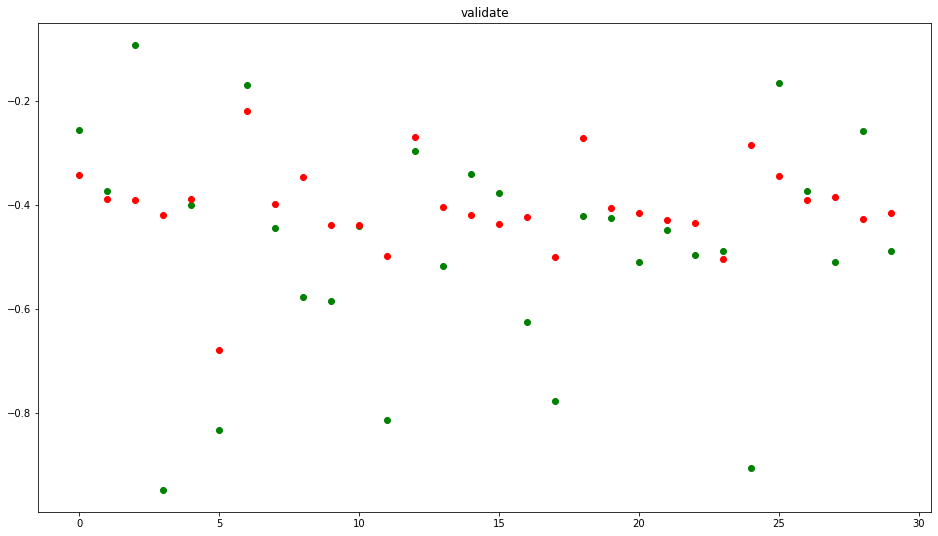

In [ ]:
results=model.predict(x_val)
print(len(results))
plt.scatter(range(len(y_val)),y_val,c="g")
plt.scatter(range(len(results)),results,c="r")
plt.title("validate")
plt.show()

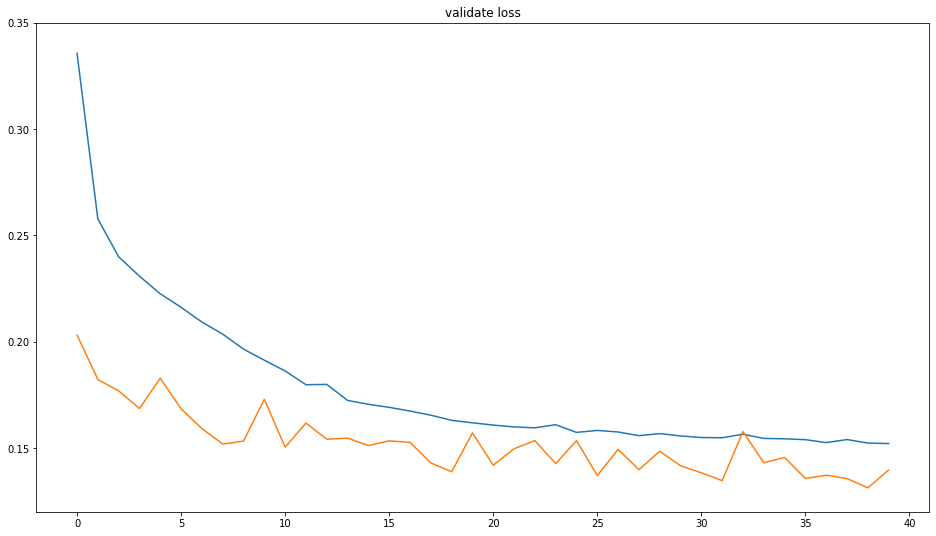

In [ ]:
plt.ylim(0.12,0.35)
plt.plot(history.history["loss"])
plt.title("loss")
plt.plot(history.history["val_loss"])
plt.title("validate loss")
plt.show()

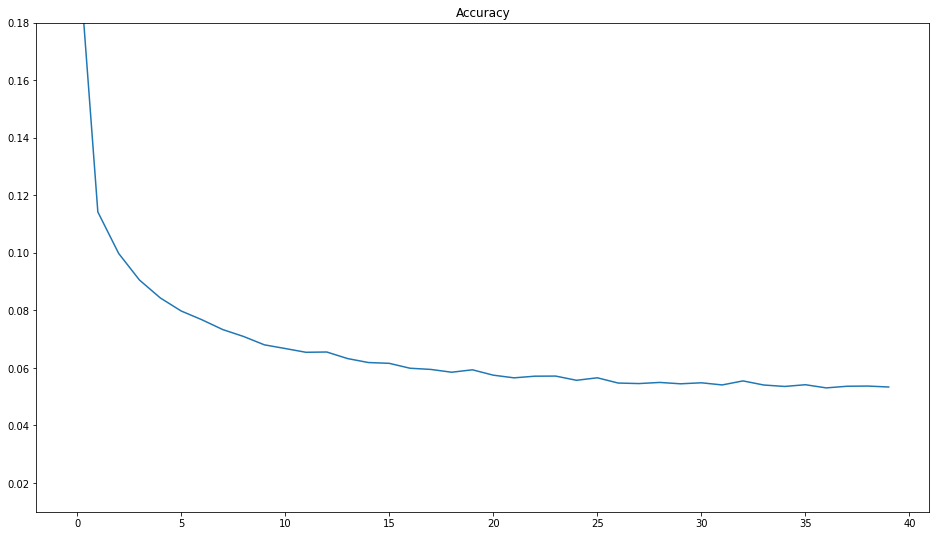

In [ ]:
plt.ylim(0.01,0.18)
plt.title("Accuracy")
plt.plot(history.history["mse"])
plt.show()

In [ ]:
compara=pd.DataFrame(np.array([y_val,[x[0] for x in results]]).transpose())
compara.columns=["real","prediccion"]

inverted=scaler.inverse_transform(compara.values)

compara2=pd.DataFrame(inverted)
compara2.columns=["real","prediccion"]
compara2["diferencia"]=compara2["real"]-compara2["prediccion"]
compara2.head(10)

,real,prediccion,diferencia
0,252.000006,228.414150,23.585855
1,220.000002,215.776182,4.223819
2,296.000009,215.348777,80.651232
3,64.999995,207.367320,-142.367325
4,212.999999,215.990979,-2.990980
5,95.999996,137.367352,-41.367356
6,274.999986,261.380957,13.619029
7,201.000000,213.289163,-12.289163
8,165.000001,227.403727,-62.403726
9,162.999996,202.148511,-39.148515


In [ ]:
compara2.describe()

,real,prediccion,diferencia
count,30.000000,30.000000,30.000000
mean,191.633332,211.850014,-20.216681
std,57.580817,22.828758,51.519418
min,64.999995,137.367352,-168.051684
25%,169.000000,203.696038,-40.371164
50%,200.499998,210.063837,-9.791808
75%,220.000002,216.844643,4.680741
max,296.000009,261.380957,80.651232


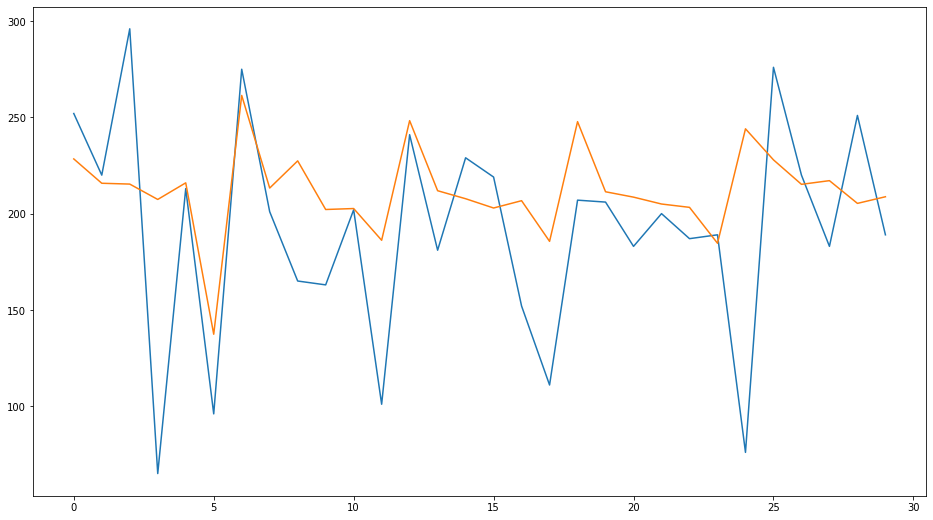

In [ ]:
compara2["real"].plot()
compara2["prediccion"].plot()

**PRONOSTICO**

---
a partir de la ultima semana de noviembre 2018, intentaremos predecir la primer semana de diciembre


In [ ]:
ultimosDias=df["2018-11-16":"2018-11-30"]
ultimosDias

,unidades,weekday,month,scaled
fecha,,,,
2018-11-16,152,4,11,-0.625926
2018-11-17,111,5,11,-0.777778
2018-11-19,207,0,11,-0.422222
2018-11-20,206,1,11,-0.425926
2018-11-21,183,2,11,-0.511111
2018-11-22,200,3,11,-0.448148
2018-11-23,187,4,11,-0.496296
2018-11-24,189,5,11,-0.488889
2018-11-25,76,6,11,-0.907407


In [ ]:
##PREPARAMOS LOS DATOS PARA TESTS
scalerdMerge=ultimosDias.drop("unidades",axis=1)
print(scaledMerge.values)

# marco como aprendizaje supervisado
reframed=series_to_supervised(scaledMerge,PASOS,1)
newReframed=reframed.drop(["var1(t)","var2(t)","var3(t)"],axis=1)
newReframed.head(7)

[[ 0.          1.         -0.31481487]
 [ 1.          1.         -0.31111115]
 [ 2.          1.         -0.11481488]
 ...
 [ 2.         11.         -0.51111114]
 [ 3.         11.         -0.25925928]
 [ 4.         11.         -0.48888892]]


,var1(t-7),var2(t-7),var3(t-7),var1(t-6),var2(t-6),var3(t-6),var1(t-5),var2(t-5),var3(t-5),var1(t-4),var2(t-4),var3(t-4),var1(t-3),var2(t-3),var3(t-3),var1(t-2),var2(t-2),var3(t-2),var1(t-1),var2(t-1),var3(t-1)
fecha,,,,,,,,,,,,,,,,,,,,,
2017-01-11,0.0,1.0,-0.314815,1.0,1.0,-0.311111,2.0,1.0,-0.114815,3.0,1.0,-0.370370,5.0,1.0,-0.714815,0.0,1.0,-0.103704,1.0,1.0,-0.225926
2017-01-12,1.0,1.0,-0.311111,2.0,1.0,-0.114815,3.0,1.0,-0.370370,5.0,1.0,-0.714815,0.0,1.0,-0.103704,1.0,1.0,-0.225926,2.0,1.0,-0.433333
2017-01-13,2.0,1.0,-0.114815,3.0,1.0,-0.370370,5.0,1.0,-0.714815,0.0,1.0,-0.103704,1.0,1.0,-0.225926,2.0,1.0,-0.433333,3.0,1.0,-0.607407
2017-01-14,3.0,1.0,-0.370370,5.0,1.0,-0.714815,0.0,1.0,-0.103704,1.0,1.0,-0.225926,2.0,1.0,-0.433333,3.0,1.0,-0.607407,4.0,1.0,-0.522222
2017-01-16,5.0,1.0,-0.714815,0.0,1.0,-0.103704,1.0,1.0,-0.225926,2.0,1.0,-0.433333,3.0,1.0,-0.607407,4.0,1.0,-0.522222,5.0,1.0,-0.644444
2017-01-17,0.0,1.0,-0.103704,1.0,1.0,-0.225926,2.0,1.0,-0.433333,3.0,1.0,-0.607407,4.0,1.0,-0.522222,5.0,1.0,-0.644444,0.0,1.0,-0.344444
2017-01-18,1.0,1.0,-0.225926,2.0,1.0,-0.433333,3.0,1.0,-0.607407,4.0,1.0,-0.522222,5.0,1.0,-0.644444,0.0,1.0,-0.344444,1.0,1.0,-0.303704


In [ ]:
values=newReframed.values
x_test= values[6:,:]
x_test = x_test.reshape((x_test.shape[0],1,x_test.shape[1]))
print(x_test.shape)
print(x_test)
ultDiaSemana=newReframed.index[len(newReframed.index)-1].weekday()

(591, 1, 21)
[[[ 1.          1.         -0.22592598 ...  1.          1.
   -0.30370373]]

 [[ 2.          1.         -0.43333334 ...  2.          1.
   -0.47407413]]

 [[ 3.          1.         -0.60740745 ...  3.          1.
   -0.45925927]]

 ...

 [[ 2.         11.         -0.51111114 ...  1.         11.
   -0.3740741 ]]

 [[ 3.         11.         -0.44814819 ...  2.         11.
   -0.51111114]]

 [[ 4.         11.         -0.49629635 ...  3.         11.
   -0.25925928]]]


In [ ]:
def agregarNuevoValor(x_test,nuevoValor,ultDiaSemana):
  for i in range(x_test.shape[2]-3):
    x_test[0][0][i]=x_test[0][0][i+3]
    ultDiaSemana=ultDiaSemana+1
  if ultDiaSemana>6:
    ultDiaSemana=0
  x_test[0][0][x_test.shape[2]-3]=ultDiaSemana
  x_test[0][0][x_test.shape[2]-2]=12
  x_test[0][0][x_test.shape[2]-1]=nuevoValor
  return x_test,ultDiaSemana

In [ ]:
#Pronostico para la "proxima semana"
results=[]
for i in range(7):
  parcial=model.predict(x_test)
  results.append(parcial[0])
  print("pred",i,x_test)
  x_test,ultDiaSemana=agregarNuevoValor(x_test,parcial[0],ultDiaSemana)

pred 0 [[[ 1.          1.         -0.22592598 ...  1.          1.
   -0.30370373]]

 [[ 2.          1.         -0.43333334 ...  2.          1.
   -0.47407413]]

 [[ 3.          1.         -0.60740745 ...  3.          1.
   -0.45925927]]

 ...

 [[ 2.         11.         -0.51111114 ...  1.         11.
   -0.3740741 ]]

 [[ 3.         11.         -0.44814819 ...  2.         11.
   -0.51111114]]

 [[ 4.         11.         -0.49629635 ...  3.         11.
   -0.25925928]]]
pred 1 [[[ 2.          1.         -0.43333334 ...  0.         12.
   -0.47061971]]

 [[ 2.          1.         -0.43333334 ...  2.          1.
   -0.47407413]]

 [[ 3.          1.         -0.60740745 ...  3.          1.
   -0.45925927]]

 ...

 [[ 2.         11.         -0.51111114 ...  1.         11.
   -0.3740741 ]]

 [[ 3.         11.         -0.44814819 ...  2.         11.
   -0.51111114]]

 [[ 4.         11.         -0.49629635 ...  3.         11.
   -0.25925928]]]
pred 2 [[[ 3.          1.         -0.60740745 ... 

In [ ]:
# Re-convertimos los resultados
adimen= [x for x in results]
print(adimen)
inverted=scaler.inverse_transform(adimen)
inverted

[array([-0.4706197], dtype=float32), array([-0.739808], dtype=float32), array([-0.9611086], dtype=float32), array([-0.96105534], dtype=float32), array([-0.91614276], dtype=float32), array([-0.9618662], dtype=float32), array([-0.9010615], dtype=float32)]


array([[193.9326872 ],
       [121.25184095],
       [ 61.50067736],
       [ 61.51506473],
       [ 73.64146065],
       [ 61.2961321 ],
       [ 77.71340806]])

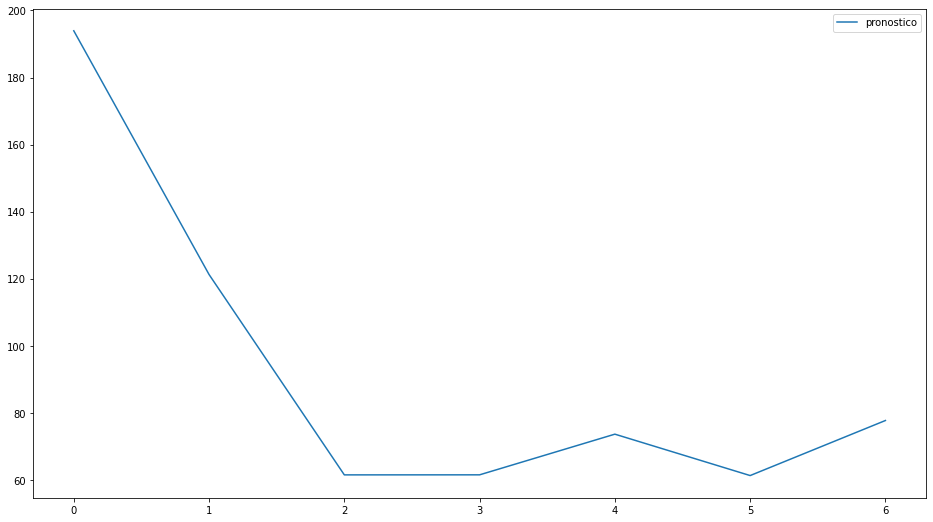

In [ ]:
#Visualizamos el pronóstico
prediccion1SemanaDiciembre=pd.DataFrame(inverted)
prediccion1SemanaDiciembre.columns=["pronostico"]
prediccion1SemanaDiciembre.plot()
prediccion1SemanaDiciembre.to_csv("pronostico_multivariante.csv")

In [ ]:
prediccion1SemanaDiciembre

,pronostico
0,193.932687
1,121.251841
2,61.500677
3,61.515065
4,73.641461
5,61.296132
6,77.713408
